In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.array as da

import json
import pickle
import warnings
import random
import zipfile 
import os
import collections
import datetime
import re
import scipy
import sys

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [2]:
path = "spotify_million_playlist_dataset.zip" #/content/drive/My Drive/АИПТ/

# Входные данные

Посмотрю, какие есть исходные признаки. Имеется 1000 кусочков исходного датасета. Буду просматривать случайный кусочек.

In [3]:
def read_slice(path, slice_):
    with zipfile.ZipFile(path, "r") as z:
      #for file_info in z.infolist():
        try:
            with z.open(slice_) as f:  
                js = f.read() 
                return json.loads(js)
        except:
            print('Slice name error')

In [4]:
number = random.randint(1, 1000)
mpd_slice = read_slice(path, 'data/mpd.slice.' + str(number * 1000 - 1000) + "-" + str(number * 1000 - 1) + '.json')

В каждом кусочке содержится информация о нем и о 1000 плейлистов:

In [6]:
mpd_slice.keys()

dict_keys(['info', 'playlists'])

Информация о кусочке не может быть использована в качестве признака при решении задачи, так как она носит ознакомительный характер. Так мы можем понять, что случайным образом открыли один из средних кусочков данных:

In [7]:
mpd_slice['info']

{'generated_on': '2017-12-03 08:41:42.057563',
 'slice': '41000-41999',
 'version': 'v1'}

In [8]:
mpd_slice['playlists'][0].keys()

dict_keys(['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'tracks', 'num_edits', 'duration_ms', 'num_artists'])

Среди данных признаков интересными для рекомендательной системы могут оказаться num_albums, num_artists, так как данные показатели будут достаточно информативными в случае, если пользователь составляет моно-плейлист, модификация duration_ms (например, средняя продолжительность треков пейлиста).

In [9]:
mpd_slice['playlists'][0]['tracks'][0].keys()

dict_keys(['pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name'])

Среди данных признаков наибольший интерес представляют позиция трека pos, название, исполнитель и альбом трека track_name, artist_name, album_name. Однако интересно не столько их конкретные названия, сколько отношения друг к другу и плейлисту. Например, в качестве дополнительных признаков можно выделить относительные величины встречаемости треков, исполнителей и альбомов как в данном плейлисте, так и на остальном множестве плейлистов.

Таким образом, на начальном этапе можно выделить следующие признаки, которые или комбинации и преобразования которых могут быть полезными:

*   num_albums
*   num_artists
*   duration_ms
*   pos
*   track_name
*   artist_name
*   album_name



# Создание БД с треками

In [17]:
def make_DataFrame(track_js):
    return pd.DataFrame.from_dict(json.loads(track_js), orient='index')

In [18]:
def make_json(track_dict):
    return json.dumps(track_dict)

In [19]:
def make_data_base(path):
    track_dict = {}
    
    with zipfile.ZipFile(path, "r") as z:
        for file_info in z.infolist():
            if ('.json' in file_info.filename) & ('mpd.slice.' in file_info.filename):
                with z.open(file_info.filename) as f:  
                    js = f.read() 
                    mpd_slice = json.loads(js)

                    for playlist in mpd_slice["playlists"]:
                        for track in playlist['tracks']:
                            if track['track_uri'] not in track_dict.keys():
                                track_dict[track['track_uri']] = {'track_name': track['track_name'], 
                                                                  'artist_name': track['artist_name'],
                                                                  'album_name': track['album_name'],
                                                                  'duration_ms': track['duration_ms']}
    return json.dumps(track_dict)

In [20]:
%%time
track_js = make_data_base(path)

Wall time: 5min 18s


In [23]:
make_DataFrame(track_js).head()

,track_name,artist_name,album_name,duration_ms
spotify:track:6QHYEZlm9wyfXfEM1vSu1P,Boots of Spanish Leather,Bob Dylan,The Times They Are A-Changin',277106
spotify:track:3RkQ3UwOyPqpIiIvGVewuU,Mr. Tambourine Man,Bob Dylan,Bringing It All Back Home,330533
spotify:track:0ju1jP0cSPJ8tmojYBEI89,Danny's Song,Loggins & Messina,The Best: Loggins & Messina Sittin' In Again,254653
spotify:track:7ny2ATvjtKszCpLpfsGnVQ,A Hard Rain's A-Gonna Fall,Bob Dylan,The Freewheelin' Bob Dylan,412200
spotify:track:18GiV1BaXzPVYpp9rmOg0E,Blowin' In the Wind,Bob Dylan,The Freewheelin' Bob Dylan,165426


In [24]:
with open('tracks.json', 'w', encoding='utf-8') as f:
    json.dump(json.loads(track_js), f, ensure_ascii=False)

In [25]:
df = make_DataFrame(track_js)

In [52]:
df.sample(5)

,track_name,artist_name,album_name,duration_ms
spotify:track:3ecvnatX2V8cjPr1NMce05,Street Hassle,Lou Reed,Street Hassle,659586
spotify:track:4vzV11MKDc82D9r1YV61MQ,Moonlight in Atlanta,Russ,Moonlight in Atlanta,163500
spotify:track:6KK3IkNcUwl5yjvNfwSYME,Evening In Space,Daphne Guinness,Optimist In Black,263626
spotify:track:6IvktxEWvlkL5KgXRSVfGV,Moshe Emet Ve'Torato Emet,Pirchei Miami,Mak'helat Ha'Yeladim - Pirchei Miami,198200
spotify:track:1NhU3JapaFWaVLYCo3Xidy,Birthday Party Invitation,社交ダンス クラブ,"(ダンス) Dancing Music: 社交ダンス, カリプソ, ソカ",225600


# Статистика по данным

Получу первичную статистику по данным.

In [53]:
class Stats:

    def __init__(self, quick=False, max_files_for_quick_processing=5):
        self.total_playlists = 0
        self.total_tracks = 0
        self.tracks = set()
        self.artists = set()
        self.albums = set()
        self.titles = set()
        self.total_descriptions = 0
        self.ntitles = set()
        self.title_histogram = collections.Counter()
        self.artist_histogram = collections.Counter()
        self.track_histogram = collections.Counter()
        self.last_modified_histogram = collections.Counter()
        self.num_edits_histogram = collections.Counter()
        self.playlist_length_histogram = collections.Counter()
        self.num_followers_histogram = collections.Counter()

        self.quick = quick
        self.max_files_for_quick_processing = max_files_for_quick_processing


    def __getstate__(self) -> dict:
        state = {}
        
        state["total_playlists"] = self.total_playlists
        state["total_tracks"] = self.total_tracks
        state["tracks"] = self.tracks
        state["artists"] = self.artists
        state["albums"] = self.albums
        state["titles"] = self.titles
        state["total_descriptions"] = self.total_descriptions
        state["ntitles"] = self.ntitles
        state["title_histogram"] = self.title_histogram
        state["artist_histogram"] = self.artist_histogram
        state["track_histogram"] = self.track_histogram
        state["last_modified_histogram"] = self.last_modified_histogram
        state["num_edits_histogram"] = self.num_edits_histogram
        state["playlist_length_histogram"] = self.playlist_length_histogram
        state["num_followers_histogram"] = self.num_followers_histogram
      
        state["quick"] = self.quick
        state["max_files_for_quick_processing"] = self.max_files_for_quick_processing

        return state
    
    # для загрузки объекта
    def __setstate__(self, state: dict):
        self.total_playlists = state["total_playlists"]
        self.total_tracks = state["total_tracks"]
        self.tracks = state["tracks"]
        self.artists = state["artists"]
        self.albums = state["albums"]
        self.titles = state["titles"]
        self.total_descriptions = state["total_descriptions"]
        self.ntitles = state["ntitles"]
        self.title_histogram = state["title_histogram"]
        self.artist_histogram = state["artist_histogram"]
        self.track_histogram = state["track_histogram"]
        self.last_modified_histogram = state["last_modified_histogram"]
        self.num_edits_histogram = state["num_edits_histogram"]
        self.playlist_length_histogram = state["playlist_length_histogram"]
        self.num_followers_histogram = state["num_followers_histogram"]

        self.quick = state["quick"]
        self.max_files_for_quick_processing = state["max_files_for_quick_processing"]

    def process_mpd(self, path, summary=False):
        count = 0

        with zipfile.ZipFile(path, "r") as z:
            for file_info in z.infolist():
                if ('.json' in file_info.filename) & ('mpd.slice.' in file_info.filename):
                    with z.open(file_info.filename) as f:  
                        js = f.read() 
                        mpd_slice = json.loads(js)

                        self.process_info(mpd_slice["info"])

                        for playlist in mpd_slice["playlists"]:
                            self.process_playlist(playlist)

                count += 1
                if self.quick and count > self.max_files_for_quick_processing:
                      break

        if summary:
            self.show_summary()

    def show_summary(self, k=20):
        print()
        print("number of playlists", self.total_playlists)
        print("number of tracks", self.total_tracks)
        print("number of unique tracks", len(self.tracks))
        print("number of unique albums", len(self.albums))
        print("number of unique artists", len(self.artists))
        print("number of unique titles", len(self.titles))
        print("number of playlists with descriptions", self.total_descriptions)
        print("number of unique normalized titles", len(self.ntitles))
        print("avg playlist length", float(self.total_tracks) / self.total_playlists)
        print()
        print("top playlist titles")
        for title, count in self.title_histogram.most_common(k):
            print("%7d %s" % (count, title))

        print()
        print("top tracks")
        for track, count in self.track_histogram.most_common(k):
            print("%7d %s" % (count, track))

        print()
        print("top artists")
        for artist, count in self.artist_histogram.most_common(k):
            print("%7d %s" % (count, artist))

        print()
        print("numedits histogram")
        for num_edits, count in self.num_edits_histogram.most_common(k):
            print("%7d %d" % (count, num_edits))

        print()
        print("last modified histogram")
        for ts, count in self.last_modified_histogram.most_common(k):
            print("%7d %s" % (count, Stats.to_date(ts)))

        print()
        print("playlist length histogram")
        for length, count in self.playlist_length_histogram.most_common(k):
            print("%7d %d" % (count, length))

        print()
        print("num followers histogram")
        for followers, count in self.num_followers_histogram.most_common(k):
            print("%7d %d" % (count, followers))

    def normalize_name(name):
        name = name.lower()
        name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", " ", name)
        name = re.sub(r"\s+", " ", name).strip()
        return name

    def to_date(epoch):
        return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d")

    def process_playlist(self, playlist):
        self.total_playlists += 1
        # print playlist['playlist_id'], playlist['name']

        if "description" in playlist:
            self.total_descriptions += 1

        self.titles.add(playlist["name"])
        nname = Stats.normalize_name(playlist["name"])
        self.ntitles.add(nname)
        self.title_histogram[nname] += 1

        self.playlist_length_histogram[playlist["num_tracks"]] += 1
        self.last_modified_histogram[playlist["modified_at"]] += 1
        self.num_edits_histogram[playlist["num_edits"]] += 1
        self.num_followers_histogram[playlist["num_followers"]] += 1

        for track in playlist["tracks"]:
            self.total_tracks += 1
            self.albums.add(track["album_uri"])
            self.tracks.add(track["track_uri"])
            self.artists.add(track["artist_uri"])

            full_name = track["track_name"] + " by " + track["artist_name"]
            self.artist_histogram[track["artist_name"]] += 1
            self.track_histogram[full_name] += 1  

    def process_info(self, _):
        pass 

In [54]:
stats = Stats()

In [55]:
%%time
stats.process_mpd(path)

Wall time: 7min 29s


In [56]:
with open("stats.pkl", "wb") as fp: #/content/drive/My Drive/АИПТ/
    pickle.dump(stats, fp)

In [57]:
with open("stats.pkl", "rb") as fp: #/content/drive/My Drive/АИПТ/
    stats = pickle.load(fp)

In [58]:
stats.show_summary(10)


number of playlists 1000000
number of tracks 66346428
number of unique tracks 2262292
number of unique albums 734684
number of unique artists 295860
number of unique titles 92944
number of playlists with descriptions 18760
number of unique normalized titles 17381
avg playlist length 66.346428

top playlist titles
  10000 country
  10000 chill
   8493 rap
   8481 workout
   8146 oldies
   8015 christmas
   6848 rock
   6157 party
   5883 throwback
   5063 jams

top tracks
  46574 HUMBLE. by Kendrick Lamar
  43447 One Dance by Drake
  41309 Broccoli (feat. Lil Yachty) by DRAM
  41079 Closer by The Chainsmokers
  39987 Congratulations by Post Malone
  35202 Caroline by Aminé
  35138 iSpy (feat. Lil Yachty) by KYLE
  34999 Bad and Boujee (feat. Lil Uzi Vert) by Migos
  34990 Location by Khalid
  34922 XO TOUR Llif3 by Lil Uzi Vert

top artists
 847160 Drake
 413297 Kanye West
 353624 Kendrick Lamar
 339570 Rihanna
 316603 The Weeknd
 294667 Eminem
 272116 Ed Sheeran
 250734 Future
 243119

На что сразу можно обратить внимание - у относительно небольшого количества плейлистов есть описание.

In [59]:
stats.total_descriptions / stats.total_playlists * 100

1.876

Только 1.8% плейлистов имеют описание, поэтому данный признак не будет использоваться.

In [60]:
stats.total_playlists / len(stats.ntitles)

57.53408894770151

Название альбома - достаточно емкий показатель, так как на каждое нормализированное название приходится в среднем 57 плейлистов, то есть данный признако может быть полезен при первичной генерации множества треков для ранжирования, однако он не может быть использован непосредственно при ранжировании.

In [61]:
stats.num_followers_histogram.most_common(1)[0][1] / stats.total_playlists * 100

75.4219

Также можно видеть, что у более чем 75% плейлистов только один подписчик, что может свидетельствовать о неинформативности данного признака.

Использование такого признака, как длина плейлиста, невозможно по причине того, что при составлении своего плейлиста пользователь редко может точно знать, сколько треков будет в нем. Поэтому, использование данного показателя - своего рода заглядывание в будущее, поэтому результаты могут быть нерепрезентативными и невоспроизводимыми в дальнейшем.

Признаки, связанные с информацией по модификации плейлиста, также не представляют интереса, так как они не являются информативной характеристикой для анализа содержательной части плейлиста.

# Количественные распределения 

Для хорошей визуализации распределений количеств различных показателей необходимо предварительно удалить выбросы, так как по предварительной статистике можно видеть, что некоторые треки, исполнители и названия присутствует в достаточно большом количестве плейлистов. 

In [62]:
def find_anomaly(data):
    q75, q25 = np.percentile(data, [75, 25])
    intr_qr = q75 - q25

    ma = q75 + (1.5 * intr_qr)
    mi = q25 - (1.5 * intr_qr)

    return data[(data < mi) | (data > ma)], data[(data >= mi) & (data <= ma)]

In [63]:
title_anomaly, title_counts = find_anomaly(np.array(list(stats.title_histogram.values())))
title_anomaly.shape[0] / len(stats.titles) * 100

1.9097521087966949

Около 2% названий плейлистов упоминается аномальное количество раз.

In [64]:
def make_hist(data, title):
    sns.distplot(data, rug=True, color='red')
    plt.xlabel(title)
    plt.show()  

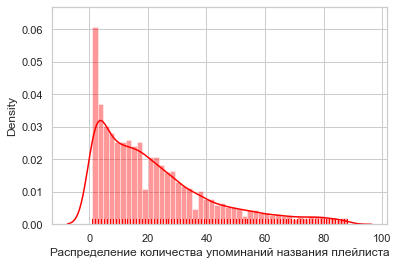

In [65]:
make_hist(title_counts, 'Распределение количества упоминаний названия плейлиста')

Большинство нормализированных названий плейлистов упоминаются в достаточно небольшом их количестве.

In [66]:
track_anomaly, track_counts = find_anomaly(np.array(list(stats.track_histogram.values())))
track_anomaly.shape[0] / len(stats.tracks) * 100

14.365696382253043

До 14% треков имеют аномальные количества упоминаний, поэтому необходимо будет продумать стратегию обработки таких треков, чтобы они не стали тривиальной рекомендацией для всех плейлистов. Решением данной проблемы может стать нормировка показателей на популярность трека.

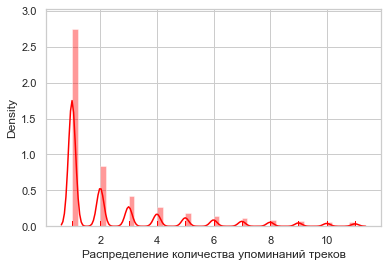

In [67]:
make_hist(track_counts, 'Распределение количества упоминаний треков')

Большиснтво треков присутствуют в 1-2 плейлистах, что может значительно сказаться не в лучшую сторону на качестве при использовании концепции совстречаемости треков.

In [68]:
artists_anomaly, artists_counts = find_anomaly(np.array(list(stats.artist_histogram.values())))
artists_anomaly.shape[0] / len(stats.artists) * 100

15.733455012505914

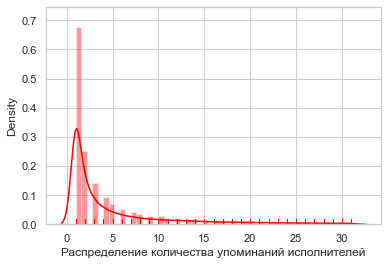

In [69]:
make_hist(artists_counts, 'Распределение количества упоминаний исполнителей')

Для исполнителей характерна та же картина, что и для треков.

# Co-occurrence matrix

Рассмотрю возможность построения матрицы совстречаемости треков. Для этого выберу случайный кусочек данных.

In [27]:
number = random.randint(1, 1000)
mpd_slice = read_slice(path, 'data/mpd.slice.' + str(number * 1000 - 1000) + "-" + str(number * 1000 - 1) + '.json')

В ячейках данной матрицы будут стоять значения количества плейлистов, в которых присуствовали оба трека, нормированные на количество плейлистов, где присуствовали данные треки.

In [28]:
def make_playlist_df(slice_):
    return pd.DataFrame.from_dict(slice_['playlists'], orient='columns')

In [29]:
def make_track_df(slice_, cols):
    df_slice = make_playlist_df(slice_)
    songs = []

    for index, row in df_slice.iterrows():
        for track in row['tracks']:
            arr = [row['pid']]
            for col in cols:
                arr.append(track[col])
            songs.append(arr)

    return pd.DataFrame(songs, columns=['pid'] + cols)

In [30]:
songs_df = make_track_df(mpd_slice, ['track_uri', 'artist_name', 'track_name'])

print(songs_df.shape)
songs_df.head(5)   

(67566, 4)


,pid,track_uri,artist_name,track_name
0,154000,spotify:track:1WP1r7fuvRqZRnUaTi2I1Q,Shawn Mendes,Stitches
1,154000,spotify:track:59uAvq0IeWRGkCJAki11ve,Shawn Mendes,Something Big
2,154000,spotify:track:4Hf7WnR761jpxPr5D46Bcd,Shawn Mendes,Treat You Better
3,154000,spotify:track:2Z6CwWW42ZqW6gUoxDhatU,Smosh,The Legend of Zelda Rap
4,154000,spotify:track:2JtZlYby65A8yYbSfNUMws,Smosh,Ultimate Assassin's Creed 3 Song


In [31]:
del mpd_slice

In [32]:
%%time
A = songs_df.drop(['artist_name', 'track_name'], axis=1).pivot_table(index=["pid"], columns="track_uri", aggfunc=lambda x: 1, fill_value=0)
print(A.shape)
A.head()

(1000, 34311)
Wall time: 10.6 s


track_uri,spotify:track:000xQL6tZNLJzIrtIgxqSl,spotify:track:0039ATfqO4FezsTcAggPyD,spotify:track:0046NsE3QgADqnrV1NDhzJ,spotify:track:005GaX6hvgeTFnR9FvejTE,spotify:track:006AVH7fq061voGXkUiII4,spotify:track:007YzRKaY8AP8kZhzjDoUM,spotify:track:007ogFejDqJKzEXDUDF8Nf,spotify:track:0088Tt3QK3fMYodhkIEoUh,spotify:track:00BHe2yBtdOzhKPmI7rpTE,spotify:track:00BuKLSAFkaEkaVAgIMbeA,...,spotify:track:7znZvX0Mt6NBmaI8VCPurT,spotify:track:7zrPswSV1yxrill5OyCuaU,spotify:track:7zscdQe9CjzXnqT3P1Ey7K,spotify:track:7zsfZMKokyicvr9hR9Xc8A,spotify:track:7ztpJweDp290g4mzNFJHGo,spotify:track:7zuqsNtIkksF5U9OEjqXlk,spotify:track:7zvzEOdelLaXM4aJYE29PT,spotify:track:7zxRMhXxJMQCeDDg0rKAVo,spotify:track:7zyo93bLysAjU08Enina9r,spotify:track:7zyqJJ0QwajaHaPLCqZFXN
pid,,,,,,,,,,,,,,,,,,,,,
154000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
del songs_df

In [34]:
%%time
A = scipy.sparse.csr_matrix(A) 

C = A.T * A
print(C.shape)

(34311, 34311)
Wall time: 356 ms


In [35]:
song_freq_vec = np.sum(A, axis=0)
song_freq_vec = song_freq_vec.reshape(A.shape[1], 1)

In [36]:
del A

In [37]:
%%time
C = da.from_array(C.toarray(), chunks=(500, 500))
song_freq_vec = da.from_array(song_freq_vec, chunks=(500, 1))

Wall time: 9.08 s


In [38]:
%%time
D = (song_freq_vec + song_freq_vec.T) - C

Wall time: 5.02 ms


In [39]:
%%time
S = da.divide(C, D)
print(S.shape)

(34311, 34311)
Wall time: 2 ms


In [40]:
del C
del D
del song_freq_vec

In [41]:
%%time
S = S.compute()

Wall time: 1min 11s


In [51]:
S.shape

(34311, 34311)

In [42]:
S.max()

1.0

In [43]:
S.min()

0.0

In [44]:
sys.getsizeof(S)

9417957888

In [45]:
%%time
S = scipy.sparse.csr_matrix(S)

Wall time: 8.51 s


In [46]:
sys.getsizeof(S)

48

In [47]:
S[S != 0].shape

(1, 6805363)

In [50]:
S[S != 0].shape[1] / (S.shape[0] * S.shape[1])

0.005780754739098975

Менее половины процента всех возможных комбинаций треков случайного кусочка данных находились в одном плейлисте.

# Итоги

В качестве потенциальных признаков выбраны следующие (для задачи формирования множества рекомендованных треков и ранжирования):

- Отношения между треками, исполнителями и альбомами (нормированная совстречаемость, доля схожих по какому-либо признаку треков). Нормировка может производиться на сумму количества плейлистов, в которых встречается каждый из рассматриваемых объектов
- Встерчаемость треков, исполнителей и альбомов в плейлистах
- Количество альбомов в плейлисте
- Количество исполнителей в плейлисте
- Продолжительность плейлиста или преобразобвание данного признака (например, средняя продолжительность треков)
- Позиции треков
- Название альбома